<a href="https://colab.research.google.com/github/vkthakur90/Monte_Carlo_Option_Pricing/blob/main/Modern_Portfolio_Theory_(Linear_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.linalg as la
import yfinance as yf
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker_list = ["BANKBEES.NS", "GOLDBEES.NS"]

ar_p = 120 # Historical Lag
ar_h = 30  # Prediction Horizon

In [4]:
def download_data(entity, ticker_list):
    data_dict = {}

    for ticker in ticker_list:
        print(f"Downloading {ticker}")

        data = yf.download(ticker, period="10y", interval="1d")

        if data.index.tzinfo is None:
            data.index = data.index.tz_localize('UTC')

        data.index = data.index.tz_convert('Asia/Kolkata')

        data_dict[ticker] = pd.Series(data['Close'].values.reshape((-1,)), index = data.index)

    data_ = pd.DataFrame(data_dict)

    entity['data'] = data_

In [5]:
def compute_daily_log_return(entity):
    log_S = entity['data'].apply(np.log)
    prev_log_S = log_S.shift(1)
    entity['daily_log_return'] = 100 * (log_S - prev_log_S)

In [6]:
def split_data(entity):
    entity['train'] = entity['data'].iloc[:-ar_h]
    entity['test'] = entity['data'].iloc[-ar_h:]

    entity['daily_log_return_train'] = entity['daily_log_return'].iloc[:-ar_h]
    entity['daily_log_return_test'] = entity['daily_log_return'].iloc[-ar_h:]

In [7]:
def feature_engineering(entity):
    features_df = entity['daily_log_return_train']

    feature_dict = {}

    for column in features_df.columns:
        for idx in range(ar_p):
            feature_dict[f'{column}_m{idx + 1}'] = features_df[column].shift(idx + 1)

        for idx in range(ar_h):
            feature_dict[f'{column}_p{idx}'] = features_df[column].shift(-idx)

    entity['train_features'] = pd.DataFrame(feature_dict).dropna()

    X_cols = []
    for col in features_df.columns:
        X_cols += [f'{col}_m{idx + 1}' for idx in range(ar_p)]

    Y_cols = []
    for col in features_df.columns:
        Y_cols += [f'{col}_p{idx}' for idx in range(ar_h)]

    entity['train_x'] = entity['train_features'][X_cols]
    entity['train_y'] = entity['train_features'][Y_cols]
    entity['train_x'].eval('Intercept = 1', inplace = True)

In [8]:
def fit_linear_model(entity):
    params = la.inv(entity['train_x'].T @ entity['train_x']) @ (entity['train_x'].T @ entity['train_y'])
    params.index = entity['train_x'].columns

    entity['params'] = params

In [9]:
def compute_residue(entity):
    entity['residue'] = entity['train_y'] - entity['train_x'] @ entity['params']

In [10]:
def compute_residual_variance(entity):
    entity['residual_variance'] = (entity['residue'].T @ entity['residue']) / (len(entity['train_x']) - (ar_p + 1) * ar_h)

In [11]:
entity = {}
download_data(entity, ticker_list)
compute_daily_log_return(entity)
split_data(entity)
feature_engineering(entity)
fit_linear_model(entity)
compute_residue(entity)
compute_residual_variance(entity)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [12]:
# Beta (coeff matrix)
entity['params']

,BANKBEES.NS_p0,BANKBEES.NS_p1,BANKBEES.NS_p2,BANKBEES.NS_p3,BANKBEES.NS_p4,BANKBEES.NS_p5,BANKBEES.NS_p6,BANKBEES.NS_p7,BANKBEES.NS_p8,BANKBEES.NS_p9,...,GOLDBEES.NS_p20,GOLDBEES.NS_p21,GOLDBEES.NS_p22,GOLDBEES.NS_p23,GOLDBEES.NS_p24,GOLDBEES.NS_p25,GOLDBEES.NS_p26,GOLDBEES.NS_p27,GOLDBEES.NS_p28,GOLDBEES.NS_p29
BANKBEES.NS_m1,0.032717,-0.134991,0.064056,-0.056867,-0.078685,0.093129,0.092098,-0.062669,0.022387,0.049255,...,0.242959,-0.025810,-0.242061,-0.032767,-0.126109,0.382562,-0.073887,-0.331790,0.129378,-0.153860
BANKBEES.NS_m2,-0.135591,0.043644,-0.061880,-0.069438,0.099847,0.084839,-0.068478,0.024540,0.041177,-0.053867,...,-0.035208,-0.242675,-0.014584,-0.128239,0.388175,-0.099610,-0.331611,0.165537,-0.154409,0.048473
BANKBEES.NS_m3,0.044097,-0.195958,-0.070876,0.103750,0.086096,-0.072943,0.021562,0.044176,-0.059313,0.105872,...,-0.240768,-0.018529,-0.124992,0.388829,-0.097991,-0.334078,0.157818,-0.146217,0.053650,0.153792
BANKBEES.NS_m4,-0.196569,-0.045937,0.100049,0.089944,-0.068638,0.020493,0.043435,-0.058331,0.103957,0.046838,...,-0.028072,-0.123980,0.395700,-0.092537,-0.324460,0.141872,-0.156820,0.061290,0.156152,-0.057218
BANKBEES.NS_m5,-0.047766,-0.105670,0.091285,-0.076016,0.022279,0.049424,-0.064939,0.114914,0.044603,0.019686,...,-0.120714,0.397270,-0.086207,-0.351025,0.112425,-0.125428,0.088195,0.157182,-0.058409,0.061345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GOLDBEES.NS_m117,0.032521,0.071896,-0.019332,-0.053663,-0.010186,-0.031456,-0.007926,0.023993,0.000463,-0.055096,...,-0.018756,-0.053628,0.130705,0.109352,-0.099581,-0.035870,-0.019751,0.182914,0.252103,-0.233862
GOLDBEES.NS_m118,0.071275,0.003009,-0.054594,-0.009877,-0.030388,-0.008377,0.023610,0.000895,-0.054060,-0.008407,...,-0.058971,0.131377,0.111282,-0.096241,-0.030759,-0.027266,0.180914,0.252846,-0.235632,-0.201011
GOLDBEES.NS_m119,-0.000347,0.017191,-0.005810,-0.046273,-0.010511,0.037232,0.002484,-0.049705,0.005416,-0.013871,...,0.122436,0.118603,-0.103899,-0.039250,-0.038462,0.202388,0.275421,-0.268630,-0.212716,-0.032767
GOLDBEES.NS_m120,0.016659,-0.004935,-0.046126,-0.011625,0.036325,0.001366,-0.049579,0.005820,-0.011103,0.020496,...,0.114723,-0.104419,-0.041522,-0.031447,0.209746,0.270096,-0.272975,-0.219725,-0.035226,0.001950


In [13]:
# Omega (variance)

entity['residual_variance']

,BANKBEES.NS_p0,BANKBEES.NS_p1,BANKBEES.NS_p2,BANKBEES.NS_p3,BANKBEES.NS_p4,BANKBEES.NS_p5,BANKBEES.NS_p6,BANKBEES.NS_p7,BANKBEES.NS_p8,BANKBEES.NS_p9,...,GOLDBEES.NS_p20,GOLDBEES.NS_p21,GOLDBEES.NS_p22,GOLDBEES.NS_p23,GOLDBEES.NS_p24,GOLDBEES.NS_p25,GOLDBEES.NS_p26,GOLDBEES.NS_p27,GOLDBEES.NS_p28,GOLDBEES.NS_p29
BANKBEES.NS_p0,-40.187616,-0.028387,36.099197,-0.136748,0.105514,0.137280,0.124325,0.381693,-0.893051,0.503637,...,-0.390233,-0.761703,0.916347,0.718647,0.039483,0.166111,-1.710506,1.487667,1.316814,-1.239835
BANKBEES.NS_p1,-0.028387,-40.185797,-0.063292,36.091300,-0.120351,0.112736,0.120213,0.114847,0.382649,-0.911263,...,-0.611455,-0.385336,-0.761442,0.947391,0.705099,0.026265,0.148873,-1.699415,1.551676,1.316542
BANKBEES.NS_p2,36.099197,-0.063292,-73.989027,-0.041017,36.064952,-0.117547,-0.160475,-0.412515,1.081196,-0.120148,...,0.828863,-0.308410,-1.186045,-0.999857,0.910872,0.688774,1.047544,-1.021817,-2.370192,2.455651
BANKBEES.NS_p3,-0.136748,36.091300,-0.041017,-74.004647,-0.051798,36.078589,-0.121584,-0.177272,-0.387205,1.086186,...,0.366522,0.789213,-0.284718,-1.138432,-1.014698,0.883147,0.695067,1.081801,-1.020389,-2.398671
BANKBEES.NS_p4,0.105514,-0.120351,36.064952,-0.051798,-73.943093,-0.050368,36.035537,-0.110302,-0.211157,-0.432287,...,0.962092,0.409583,0.757974,-0.286810,-1.078623,-0.943313,0.794065,0.568866,1.171043,-0.960832
BANKBEES.NS_p5,0.137280,0.112736,-0.117547,36.078589,-0.050368,-73.950540,-0.023689,36.056674,-0.129941,-0.216560,...,-0.985337,1.004241,0.396945,0.711527,-0.299868,-1.085131,-0.903088,0.767255,0.545191,1.214433
BANKBEES.NS_p6,0.124325,0.120213,-0.160475,-0.121584,36.035537,-0.023689,-73.893871,-0.044486,36.106085,-0.117442,...,-0.992992,-1.040698,1.037336,0.441402,0.606460,-0.396784,-0.998986,-0.791075,0.750020,0.527527
BANKBEES.NS_p7,0.381693,0.114847,-0.412515,-0.177272,-0.110302,36.056674,-0.044486,-73.921226,-0.011583,36.096397,...,1.555704,-1.057692,-1.047595,1.084943,0.462726,0.653688,-0.479009,-1.026159,-0.745966,0.741737
BANKBEES.NS_p8,-0.893051,0.382649,1.081196,-0.387205,-0.211157,-0.129941,36.106085,-0.011583,-73.956026,0.028490,...,-1.985814,1.578213,-1.037410,-1.104713,1.057750,0.429535,0.714173,-0.406826,-1.098725,-0.768824
BANKBEES.NS_p9,0.503637,-0.911263,-0.120148,1.086186,-0.432287,-0.216560,-0.117442,36.096397,0.028490,-73.902218,...,-0.046480,-2.076748,1.573687,-1.071921,-1.030291,1.145650,0.393899,0.674035,-0.563682,-1.136488


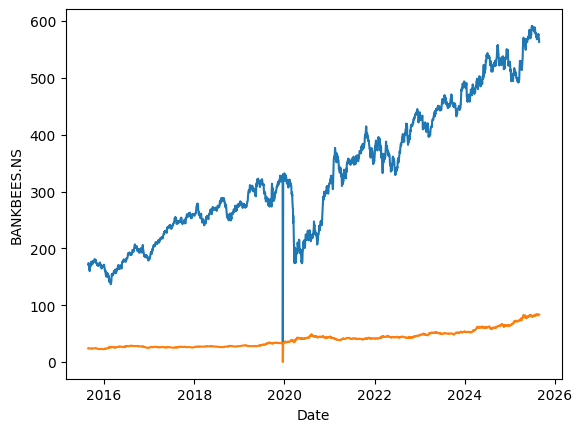

In [14]:
for ticker in ticker_list:
    sns.lineplot(x = "Date", y = ticker, data = entity["data"].reset_index())

<Axes: >

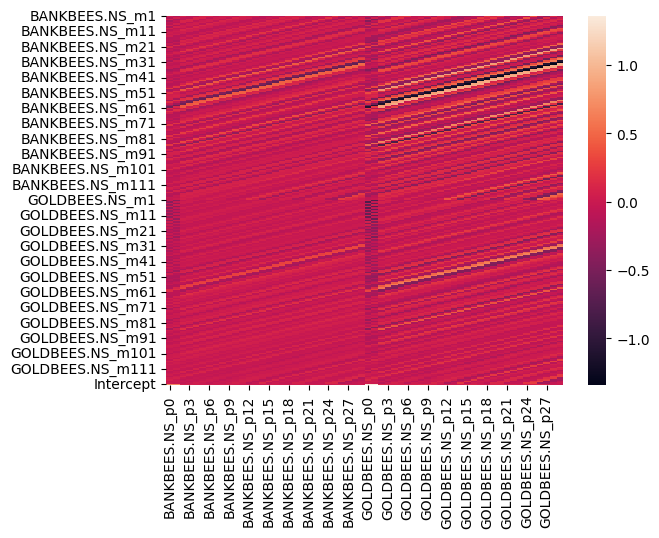

In [15]:
# Beta
sns.heatmap(entity['params'])

<Axes: >

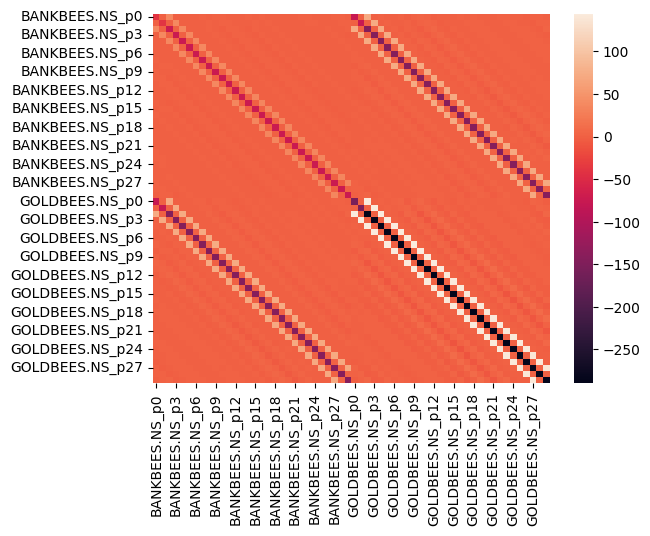

In [16]:
# Omega
sns.heatmap(entity['residual_variance'])